Load the required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import obspy

from obspy.signal.konnoohmachismoothing import konno_ohmachi_smoothing

import pykooh

%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 150

# Comparison between the `obspy` and `pyko`

Load an example time series.

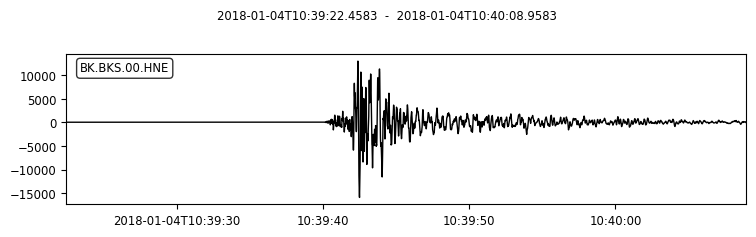

In [3]:
trace = obspy.read('tests/data/example_ts.mseed').traces[0]
trace.plot();

Compute the Fourier amplitudes and apply the smoothing operators.

In [4]:
fourier_amps = np.abs(np.fft.rfft(trace.data))
freqs = np.fft.rfftfreq(len(trace), d=trace.stats['delta'])

In [5]:
b = 188.5
ko_amps = konno_ohmachi_smoothing(fourier_amps, freqs, b, normalize=True)

In [6]:
pyko_amps = pykooh.smooth(freqs, freqs, fourier_amps, b)

Plot the smoothing from `obspy` and `pyko`.

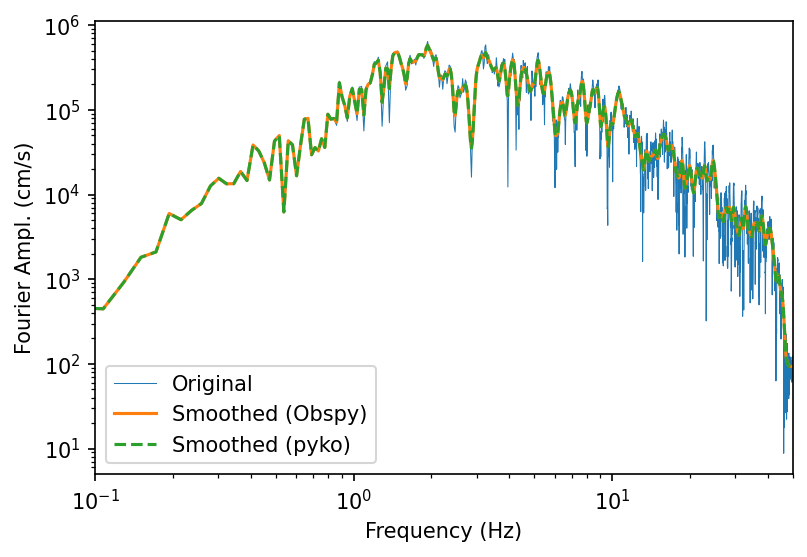

In [7]:
fig, ax = plt.subplots()
ax.plot(freqs, fourier_amps, label='Original', linewidth=0.5)
ax.plot(freqs, ko_amps, label='Smoothed (Obspy)')
ax.plot(freqs, pyko_amps, label='Smoothed (pyko)', linestyle='--')
ax.set(
    xlabel='Frequency (Hz)', xscale='log', xlim=(0.1, 50),
    ylabel='Fourier Ampl. (cm/s)', yscale='log'
)
ax.legend()
fig;

Save data to be used for test cases.

In [8]:
np.savez(
    'tests/data/test_data.npz',
    freqs=freqs, fourier_amps=fourier_amps,
    ko_amps=pyko_amps, b=b
)

# Calculation time

In [9]:
%time _ = konno_ohmachi_smoothing(fourier_amps, freqs, b, normalize=True)

CPU times: user 273 ms, sys: 81 µs, total: 273 ms
Wall time: 273 ms


In [10]:
%time _ = pykooh.smooth(freqs, freqs, fourier_amps, b, use_cython=True)

CPU times: user 9.91 ms, sys: 0 ns, total: 9.91 ms
Wall time: 9.89 ms


Call once to compile the `numba` functions.

In [11]:
pykooh.smooth(freqs, freqs, fourier_amps, b, use_cython=False)

%time _ = pykooh.smooth(freqs, freqs, fourier_amps, b, use_cython=False)

CPU times: user 3.96 s, sys: 72 µs, total: 3.96 s
Wall time: 3.97 s


`Cython` and `numba` implementations provide very similar speed ups.

# Effective amplitude calculation

In [12]:
def read_at2(fname):
    with open(fname) as fp:
        for _ in range(3):
            next(fp)
        time_step = float(next(fp).split()[3])
        accels = np.array([p for l in fp for p in l.split()]).astype(float)
    return time_step, accels

In [13]:
time_step, accels_h1 = read_at2('./tests/data/RSN4863_CHUETSU_65036EW.AT2')
accels_h2 = read_at2('./tests/data/RSN4863_CHUETSU_65036NS.AT2')[1]

accels = np.c_[accels_h1, accels_h2]

In [14]:
fourier_amps = np.fft.rfft(accels, axis=0)
freqs = np.fft.rfftfreq(accels.shape[0], d=time_step)

In [15]:
freqs_ea, eff_ampl = pykooh.effective_ampl(freqs, fourier_amps[:, 0], fourier_amps[:, 1], missing='nan')

Mask out the missing values.

In [16]:
mask = ~np.isnan(eff_ampl)

Create a little comparison plot.

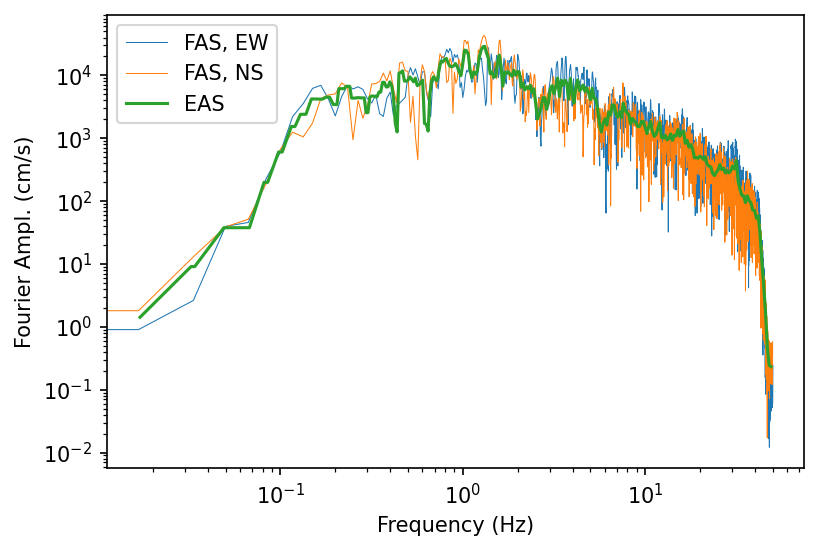

In [17]:
to_cmps = 981.

fig, ax = plt.subplots()

ax.plot(freqs, np.abs(fourier_amps) * to_cmps, linewidth=0.5)
ax.plot(freqs_ea[mask], eff_ampl[mask] * to_cmps, label='EAS')
ax.set(
    xlabel='Frequency (Hz)', xscale='log',
    ylabel='Fourier Ampl. (cm/s)', yscale='log'
)
ax.legend(
    ax.get_lines(),
    ['FAS, EW', 'FAS, NS', 'EAS'],
)
fig;